In [532]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set_style("darkgrid")
import warnings
warnings.filterwarnings('once')

In [533]:
#Read Training File
df_train=pd.read_csv("train.csv")
df_train["source"]="Train"

#Read Test File
df_test=pd.read_csv("test.csv")
df_test["source"]="Test"

#Concat Dataset and split to X and Y
df=pd.concat([df_test,df_train], axis=0)
X=df.drop("SalePrice",axis=1)
y=df["SalePrice"]

#Save source information as series and drop from DF
source=df["source"]
df.drop("source", axis=1, inplace=True)

C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


# Feature Engineering: Cleaning

In [534]:
# Defining categorical and numerical variables
num_cols=X.columns.values[(X.dtypes=="int64")|(X.dtypes=="float64")]
cat_cols=X.columns.values[X.dtypes=="object"]

### False num_cols to categorical

In [535]:
num_cols

array(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
       'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea',
       'GarageCars', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'Id',
       'KitchenAbvGr', 'LotArea', 'LotFrontage', 'LowQualFinSF',
       'MSSubClass', 'MasVnrArea', 'MiscVal', 'MoSold', 'OpenPorchSF',
       'OverallCond', 'OverallQual', 'PoolArea', 'ScreenPorch',
       'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt',
       'YearRemodAdd', 'YrSold'], dtype=object)

In [536]:
# MSSubClass: Identifies the type of dwelling involved in the sale.	
# MoSold: Month Sold (MM)
# YrSold: Year Sold (YYYY)
# OverallCond: Rates the overall condition of the house
# OverallQual: Rates the overall material and finish of the house
# YearBuilt
# YearRemodAdd

false_nums = ["MSSubClass","MoSold","YrSold","OverallCond","OverallQual","YearBuilt","YearRemodAdd"]

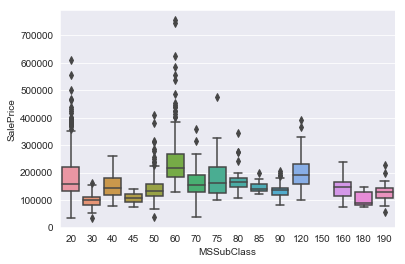

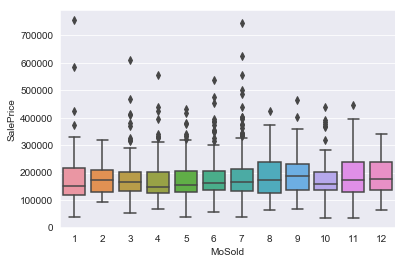

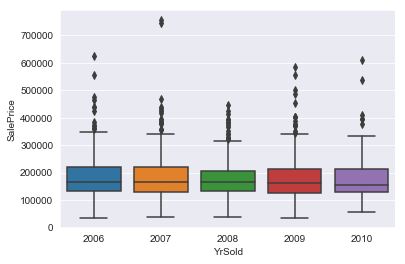

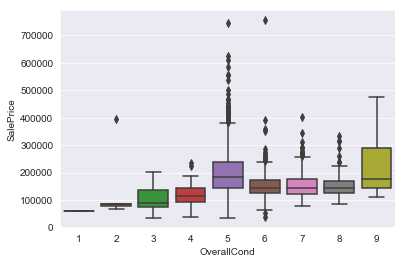

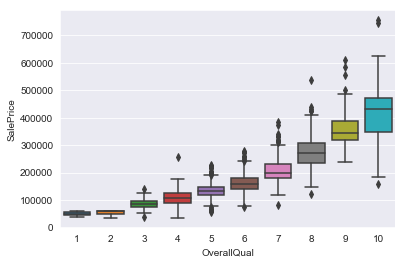

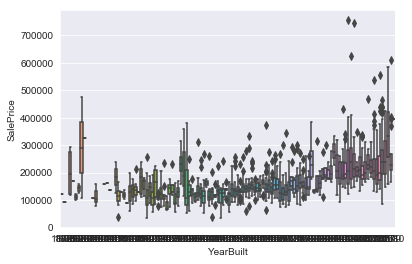

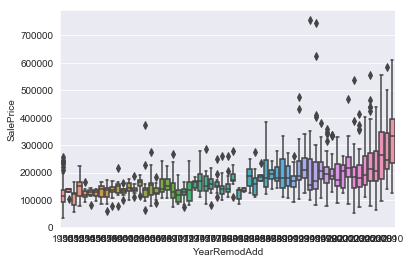

In [537]:
for each in false_nums:
    plt.figure()
    sns.boxplot(X[each],y=y)

YearBuild and YearRemodAdd are kept as continuous, because they are "streng monoton steigent" and would cause to much additional variables.

In [538]:
false_nums = ["MSSubClass","MoSold","YrSold","OverallCond","OverallQual"]

for each in false_nums:
    X[each]=X[each].astype("object")

In [539]:
# Defining categorical and numerical variables
num_cols=X.columns.values[(X.dtypes=="int64")|(X.dtypes=="float64")]
cat_cols=X.columns.values[X.dtypes=="object"]

### Outlier/Data Errors

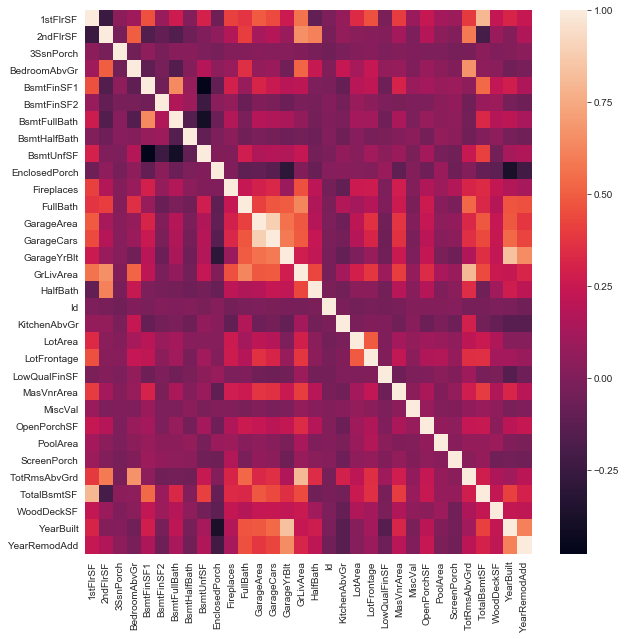

In [540]:
plt.figure(figsize=(10,10))
sns.heatmap(X[num_cols].corr())

### Missing Values

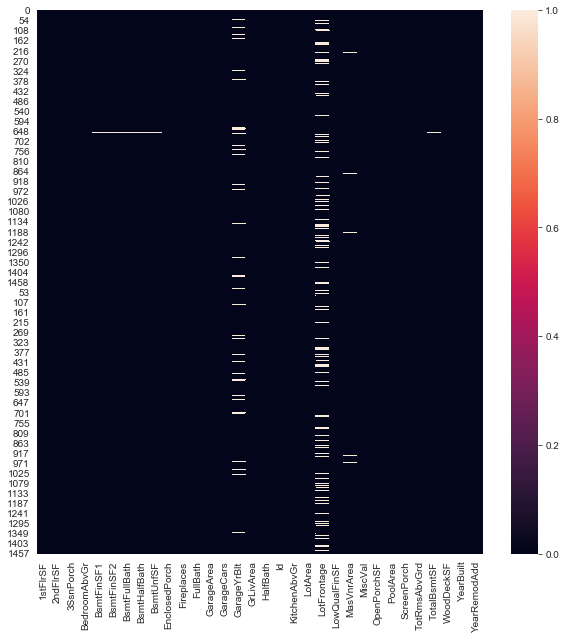

In [541]:
plt.figure(figsize=(10,10))
sns.heatmap(X[num_cols].isnull())

- Deep dive into "GarageYrBlt" and "Lot Frontage"
 - "GarageYrBlt" => insert "YearBuild"
 - "Lot Frontage" => median
- Replace all others with Median Value

In [542]:
# Replace "GarageYrBlt"
X["GarageYrBlt"].describe()

count    2760.000000
mean     1978.113406
std        25.574285
min      1895.000000
25%      1960.000000
50%      1979.000000
75%      2002.000000
max      2207.000000
Name: GarageYrBlt, dtype: float64

In [543]:
X["GarageYrBlt"]=X["GarageYrBlt"].fillna(X["YearBuilt"])

In [544]:
#Fill other columns
for each in X[num_cols]:
    X[each]=X[each].fillna(np.mean(X[each]))
    #X[each]=X[each].fillna(0)

### Normalization

In [545]:
# Standardize 
for each in X[num_cols]:
    #X[each] = (X[each]-X[each].min())/(X[each].max()-X[each].min())
    X[each] = (X[each]-X[each].mean())/(X[each].std())

### One-Hot-Encoding

In [546]:
for each in cat_cols:
    X[each]=pd.Categorical(X[each])
    dummies=pd.get_dummies(X[each], prefix=str(each))
    #dummies=dummies[1:]
    X=pd.concat([X,dummies],axis=1)
    X.drop(each,axis=1,inplace=True)

## Split Training and Test

In [547]:
#Split Set (using source)
def sync_datasets(X,y):
    X_train = X[source=="Train"]
    y_train = y[source=="Train"]
    X_test= X[source=="Test"]
    return X_train, y_train, X_test

X_train, y_train, X_test = sync_datasets(X,y)

In [548]:
X.shape

(2919, 338)

# Feature Selection

In [549]:
from sklearn.ensemble import RandomForestRegressor
RandomForest = RandomForestRegressor()

### Drop non-corelating variables

In [550]:
#correlations=pd.concat([X,y], axis=1).corr()["SalePrice"]
#keep_cols=(abs(correlations)>0.1) & (correlations<1)
#keep_cols=keep_cols[0:291]
#Das muss noch anders gelöst werden
#X=X[X.columns.values[keep_cols]]

### Recursive Feature Selection
This step should help us to get on idea on the right number of parameters.

In [551]:
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE

In [552]:
rfecv = RFECV(estimator=lasso,scoring="explained_variance", step=5, cv=6 )
rfecv.fit(X=X_train,y=y_train)

C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\sklearn\linear_model\coo

RFECV(cv=6,
   estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
   n_jobs=1, scoring='explained_variance', step=5, verbose=0)

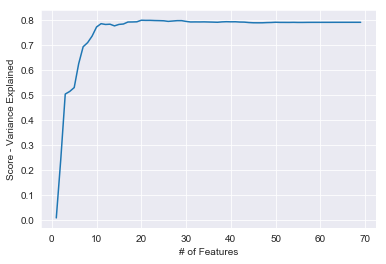

Optimal number of features 93


In [553]:
# Plot relationship #of features and performance
plt.plot(range(1, len(rfecv.grid_scores_)+1), rfecv.grid_scores_)
plt.xlabel("# of Features")
plt.ylabel("Score - Variance Explained")
plt.show()
print("Optimal number of features {}".format(rfecv.n_features_))

In [520]:
#rfe = RFE(xgb_tuned, 10)
#rfe.fit(X=X_train,y=y_train)

[14:21:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:23] WARNI

RFE(estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
  n_features_to_select=10, step=1, verbose=0)

In [559]:
#Select important columns
#selected_cols=X_train.columns.values[rfecv.support_]
selected_cols=X_train.columns.values[rfe.support_]
X_train=X_train[selected_cols]
X_test=X_test[selected_cols]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 338 but corresponding boolean dimension is 73

In [560]:
X_train.shape

(1460, 338)

# Feature Engineering: Creative

## Dependent Variable

(array([148., 723., 373., 135.,  51.,  19.,   4.,   3.,   2.,   2.]),
 array([ 34900., 106910., 178920., 250930., 322940., 394950., 466960.,
        538970., 610980., 682990., 755000.]),
 <a list of 10 Patch objects>)

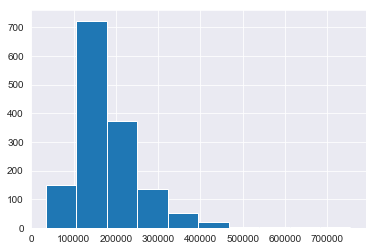

In [458]:
plt.hist(y_train)

(array([  5.,  12.,  54., 184., 470., 400., 220.,  90.,  19.,   6.]),
 array([10.46024211, 10.7676652 , 11.07508829, 11.38251138, 11.68993448,
        11.99735757, 12.30478066, 12.61220375, 12.91962684, 13.22704994,
        13.53447303]),
 <a list of 10 Patch objects>)

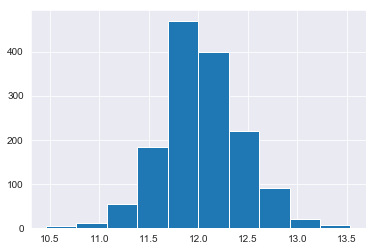

In [459]:
plt.hist(np.log(y_train))

In [460]:
#y_train=np.log(y_train)

# Train Models

In [461]:
#Random Forest Regressor
RandomForest.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [462]:
from sklearn.linear_model import LinearRegression
Regression=LinearRegression()
Regression.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [463]:
from sklearn.svm import SVR
SVR=SVR()
SVR.fit(X_train,y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [464]:
from sklearn.ensemble import AdaBoostRegressor
Ada=AdaBoostRegressor()
Ada.fit(X=X_train,y=y_train)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=None)

In [465]:
from sklearn.ensemble import GradientBoostingRegressor
Boosting=GradientBoostingRegressor()
Boosting.fit(X=X_train,y=y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [466]:
import xgboost as xgb
boost=xgb.XGBRegressor()
boost.fit(X_train,y_train)

C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:46:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [561]:
from sklearn.linear_model import Lasso
lasso = Lasso()
lasso.fit(X_train,y_train)

C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [468]:
from sklearn.ensemble import BaggingRegressor
bagging = BaggingRegressor()
bagging.fit(X_train,y_train)

BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
         verbose=0, warm_start=False)

In [469]:
from sklearn.ensemble import ExtraTreesRegressor
extra = ExtraTreesRegressor()
extra.fit(X_train,y_train)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

In [470]:
#model = [lasso,boost, Regression, RandomForest, SVR, Ada,Boosting]
model = [boost,extra, bagging, lasso, Regression, RandomForest, SVR, Ada,Boosting]

## Cross-Validation for Model Selection

In [471]:
from sklearn.model_selection import cross_val_score

In [269]:
for each in model:
    scores = cross_val_score(estimator=each,X=X_train, y=y_train, cv=6,scoring='mean_squared_error') 
    print(str(each)+" "+str(scores.mean()))

C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:59:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:59:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:59:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:59:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:59:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:59:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1) -0.020070822661910834


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False) -0.025929191765112252


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
         verbose=0, warm_start=False) -0.0247304903341148
Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False) -0.1595162548543162
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False) -0.02539250699430617


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False) -0.025584718401765683


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False) -0.02086005207532959


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=None) -0.03589205931828033


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False) -0.020432326673824188


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


# Hyperparameter - Tuning

In [270]:
from sklearn.model_selection import GridSearchCV

In [501]:
#params = {"min_samples_leaf":[1,2,3,5,10,15], "min_samples_split": [2,3,5,10,15]}
#params = {"min_child_weight":[1,2,3,5,10,15]}
params = {"alpha":[0.1, 0.3, 0.5, 0.9], "learning_rate": [0.05,0.1,0.2],"min_samples_leaf":[1,2,3,5,10]}


In [502]:
tuning = GridSearchCV(Boosting,cv=5, param_grid=params)
tuning.fit(X_train, y_train)
tuning.best_params_

{'alpha': 0.9, 'learning_rate': 0.2, 'min_samples_leaf': 2}

In [523]:
xgb_tuned = xgb.XGBRegressor()
xgb_tuned.fit(X_train, y_train)
scores = cross_val_score(estimator=xgb_tuned,X=X_train, y=y_train, cv=10,scoring='explained_variance') 
print(scores.mean())

C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:22:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:22:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:22:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:22:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:22:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.8253236899804943


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [516]:
boosted_tuned = GradientBoostingRegressor()
boosted_tuned.fit(X_train, y_train)
scores = cross_val_score(estimator=boosted_tuned,X=X_train, y=y_train, cv=10,scoring='explained_variance') 
print(scores.mean())

0.8828959580606222


# Prediction

In [475]:
#Build Esemble

In [477]:
#Custom ensemble
model = [xgb_tuned,boost,extra, bagging, RandomForest, SVR]
weights = [0.3, 0.2, 0.2, 0.1, 0.1, 0.1]

array = {}
i=1

for each in model:
    array[i] = each.predict(X_test)
    i=i+1

ensemble_reg = np.zeros(1459)

for each in range(1, len(weights)+1):
    ensemble_reg=ensemble_reg + array[each]*weights[each-1]
    
#ensemble_reg

In [524]:
prediction = xgb_tuned.predict(X_test)

In [508]:
# Reverting log
#prediction = np.exp(ensemble_reg)

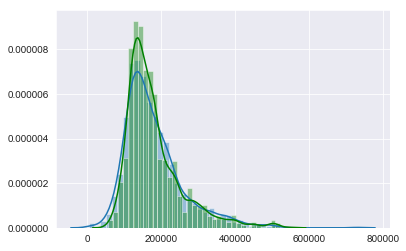

In [567]:
sns.distplot(lasso.predict(X_test))
sns.distplot(prediction, color="green")

In [526]:
# Writing Prediction to *.csv
submission = pd.read_csv("sample_submission.csv")
submission["SalePrice"]=prediction
submission.to_csv("submission.csv", index=False)

# Learnings

- Vor one-hot-enconding training und test dataset zusammen 
- What is a stratified fold?
- Variance explained for Regression?

# Results

1. Submit: Just one hot-encoding and Random Forest (Default): 0.15554
2. Submit: One hot-encoding and Random Forest (Default), RFECV: 0.15051 (2.857)
3. Submit: Like 2, +Log Target Variable, +Fill missing values with mean instead of 0:
4. Submit: Like 3, - Fill missing values with mean instead of 0: 0.15727
5. Submit: Normalized, median as input, pre-selected features: 0.16282
6. Submit: Model - Regression: 0.16721
7. Submit: Model - Boosting:0.19108 => overfitting
8. Submit: Random Forest, + Missing Values (Garage) + Standardization (just for nums) + Garage NaN more sophisticated:  0.15394
9. Submit: Wie 8, bloß mit Hyperparameter Tuning: 0.16575
10. Submit: gxboost: 0.13471
11. Submit: Random Forest, +Num to cols, +Log Target: 0.15785
12. Submit: like 11, with SVR: 0.14918
13. Submit: like 12, with gxb: 0.14512
14. Submit: like 13, with gxb (50 features): 0.15381
15. Submit: like 14, custom ensemble: 0.14741
16. Submit: like 15, drop log: 0.14743
17. Submit: like 16, with prediction + 5000: 0.15298
18. Submit: gxboost_tuned incl. specific RFECV: 0.14984
19. Submit: GradientBoostingRegressor: 0.15016
20. Submit: XGB with only top 10 features: 0.18058

In [ ]:
prediction

# Ideas
- Engineering
 - Remove colinearity
- More Algos

- Stacked prediction model (also Linear Models)
- Robust against outlier

=> xgboost less overfitting